In [1]:
import numpy as np
from numpy import array, eye, sqrt, zeros, exp
from numpy.random import randn, rand
from numpy.linalg import norm, solve

from scipy.linalg import qr
from scipy.optimize import fsolve
from scipy.stats import multivariate_normal as MVN

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

from autograd import jacobian
import autograd.numpy as anp

- Function $f:\mathbb{R}^3\to\mathbb{R}^2$
$$
f(\theta) = 
\begin{pmatrix}
    \theta_1^2 + 3\theta_0^2(\theta_0^2 - 1) - \theta_2^2 \\
    \theta_2^2 + 3\theta_1^2(\theta_1^2 - 1) - \theta_0^2
\end{pmatrix}
$$
- Jacobian $J_f(\theta)\in\mathbb{R}^{2\times 3}$
$$
J_f(\theta) = 
\begin{pmatrix}
    12\theta_0^3 - 6\theta_0 & 2\theta_1 & -2\theta_2 \\
    12\theta_1^3 - 6\theta_1 & 2\theta_2 & -2\theta_0
\end{pmatrix}
$$

## Check Multivariate Hug Works

In [2]:
# def f(θ):
#     return array([
#         θ[1]**2 + 3*(θ[0]**2)*(θ[0]**2 - 1) - θ[2]**2,
#         θ[2]**2 + 3*(θ[1]**2)*(θ[1]**2 - 1) - θ[0]**2])

# need to create a new function
# def f(θ):
#     return anp.array([
#         (θ[1]**2)*(1 - θ[2]**2) + 3*(θ[0]**2)*(θ[0]**2 - 1),
#         (θ[2]**2)*(1 - θ[1]**2) + 3*(θ[0]**2)*(θ[0]**2 - 1)
#     ])

# def Jf(θ):
#     return array([
#         [12*θ[0]**3 - 6*θ[0], 2*θ[1]*(1 - θ[2]**2), -2*(θ[1]**2)*θ[2]],
#         [12*θ[0]**3 - 6*θ[0], -2*(θ[2]**2)*θ[1], 2*θ[2]*(1 - θ[1]**2)]
#     ])

def f(θ):
    return anp.array([
        (θ[0]*θ[1])**2 + (θ[1]*θ[2])**2,
        (θ[1]*θ[2])**2 + (θ[0]*θ[2])**2
    ])

def Jf(θ):
    return array([
        [2*θ[0]*(θ[1]**2), 2*(θ[0]**2)*θ[1] + 2*θ[1]*(θ[2]**2), 2*(θ[1]**2)*θ[2]],
        [2*θ[0]*θ[2]**2, 2*θ[1]*θ[2]**2, 2*(θ[1]**2)*θ[2] + 2*(θ[0]**2)*θ[2]]
    ])

# def Jf(θ):
#     return array([
#         [12*θ[0]**3 - 6*θ[0], 2*θ[1], -2*θ[2]],
#         [12*θ[0]**3 - 6*θ[0], -2*θ[1], 2*θ[2]]
#     ])

# def Jf(θ):
#     return array([
#         [12*θ[0]**3 - 6*θ[0], 2*θ[1], -2*θ[2]],
#         [-2*θ[0], 12*θ[1]**3 - 6*θ[1], 2*θ[2]]
#     ])

# Jf_autograd = jacobian(f)
Jf_autograd = jacobian(f)


def sample_prior():
    return randn(3)

def sample_velocity():
    return randn(3)

In [3]:
# Sample a parameter from prior
θ = sample_prior()               # (3,)

# Compute transpose of Jacobian
JT = Jf(θ).T                     # (3, 2)

# Compute economic QR decomposition
Q, R = qr(JT, mode='economic')

# Sample a velocity
v = sample_velocity()

# Update velocity
w = (eye(3) - 2*Q@Q.T) @ v

# Check norms are the same
norm(v) - norm(w)

5.551115123125783e-17

In [4]:
def something(JT, v):
    # thing to subtract
    sub = JT @ (JT.T @ v)
    sub_norm = sub / norm(sub)
    return v - 2 * sub_norm

def something2(JT, v):
    # first step
    first       = JT.T @ v
    first_norm  = first / norm(first)
    second      = JT @ first
    second_norm = second / norm(second)
    return v - 2*second

def something3(JT, v):
    # normalize columns of JT
    JTnorm = JT / norm(JT, axis=0)
    return v - 2 * JTnorm @ (JTnorm.T @ v)

def something4(JT, v):
    w = v - 2 * JT @ (JT.T @ v)
    return w * norm(v) / norm(w)

def something5(JT, v):
    return v - 2 * JT @ solve(JT.T @ JT, JT.T @ v)

def standard_computation(JT, v):
    Q, _ = qr(JT, mode='economic')
    return v - 2 * Q @ (Q.T @ v)

In [5]:
def coincident(one, two):
    return np.dot(one,two)*np.dot(one,two) == np.dot(one,one)*np.dot(two,two)

In [6]:
def check_reversibility(x, v, δ=2):
    def move_bounce_move(x, v, δ=2):
        x0 = x
        # Move
        xh = x0 + (δ/2)*v
        # Bounce
        JT = Jf(xh).T
        Q, _ = qr(JT, mode='economic')
        v = v - 2 * Q @ (Q.T @ v)
        # Move
        x = xh + (δ/2)*v
        return x, v
    # Go forwards
    x1, v1 = move_bounce_move(x, v)
    # Go backwards
    x2, v2 = move_bounce_move(x1, -v1)
    return np.max(abs(x - x2)), np.max(abs(v + v2))

# Visualize Manifold and Velocity Bounce

Manifold for some $y\in\mathbb{R}^2$ is
$$
\mathcal{M} = f^{-1}(y) = \{\theta\in\mathbb{R}^3\,:\, f(\theta) = y\}.
$$
This manifold now has dimension $\dim(\mathcal{M}) = 1$ and $\text{codim}(\mathcal{M}) = 2$

In [7]:
# Choose data
y = array([1., 1.])

# Number of points
N = 10000

In [8]:
θs = np.vstack([sample_prior() for _ in range(N)])

In [9]:
ys = array([f(θ) for θ in θs])

In [10]:
def find_point(y, maxiter=100):
    found = False
    i = 0
    while not found or i < maxiter:
        θ = sample_prior()
        fprime = lambda θ: np.vstack((Jf(θ), zeros(3)))
        out = fsolve(lambda θ: array([*(f(θ) - y), 0]), θ, fprime=fprime)
        i += 1
        if np.array_equal(f(out), y):
            found = True
    return out

In [13]:
point = find_point(y)

In [14]:
# grab a point among _points_ at random
x = point #points[10, :]
v = sample_velocity()
JT = Jf(x + v).T
Q, R = qr(JT, mode='economic')

# Compute new velocity 
w = v - 2 * Q @ (Q.T @ v)

In [16]:
def mHug(x0, T, B, N, q, logpi, jac):
    """Multidimensional Hug sampler."""
    samples, acceptances = x0, np.zeros(N)
    for i in range(N):
        v0 = q.rvs()
        v, x = v0, x0
        logu = np.log(rand())
        δ = T / B
        for _ in range(B):
            x = x + δ*v/2
            Q, _ = qr(jac(x).T, mode='economic')
            v = v - 2 * Q @ (Q.T @ v)
            x = x + δ*v/2
        if logu <= logpi(x) + q.logpdf(v) - logpi(x0) - q.logpdf(v0):
            samples = np.vstack((samples, x))
            acceptances[i] = 1         # Accepted!
            x0 = x
        else:
            samples = np.vstack((samples, x0))
            acceptances[i] = 0         # Rejected
    return samples[1:], acceptances

In [17]:
T = 1.0
B = 5
N = 50000
q = MVN(zeros(3), eye(3))
ϵ = 0.01
logpi = lambda ξ: -0.5*(ξ@ξ) - (norm(f(ξ) - y)**2) / (2*(ϵ**2))

x = point #points[1, :]

In [18]:
samples, acceptances = mHug(x, T, B, N, q, logpi, Jf)

In [19]:
acceptances.mean() * 100

45.617999999999995

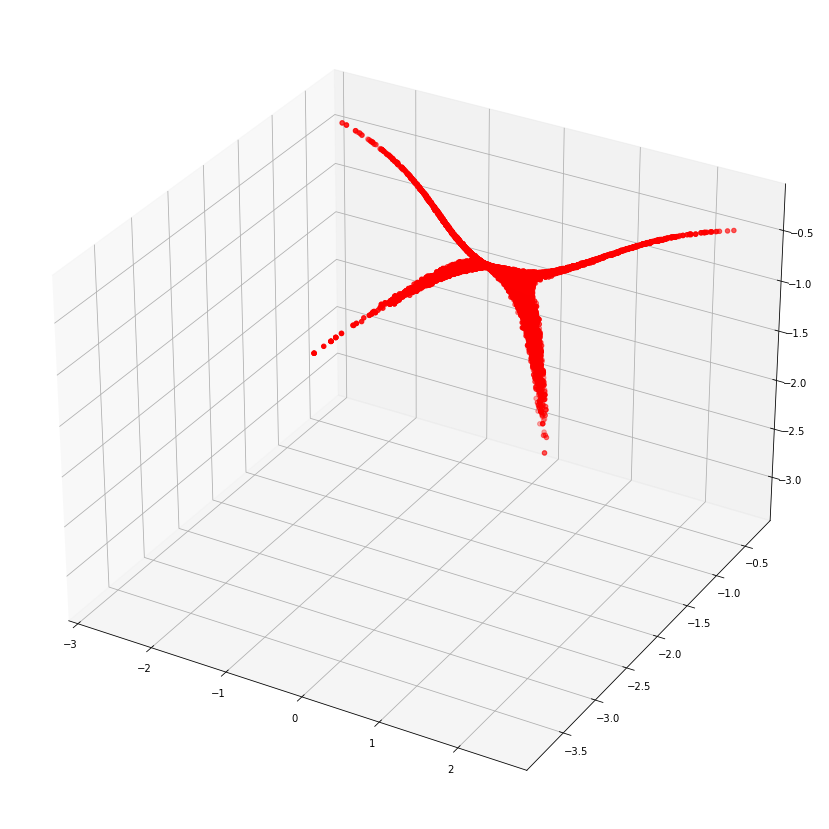

In [20]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(*points.T)
# ax.scatter(*x, color='k', s=100)
# ax.scatter(*(x + v), color='k', s=100)
# ax.scatter(*(x+v+w), color='violet', s=100)
ax.scatter(*samples.T, color='red')
# ax.quiver(*x, *v, arrow_length_ratio=0.1, color='red')
# ax.quiver(*(x+v), *w, arrow_length_ratio=0.1, color='ForestGreen')
ax.view_init(30, -60)
plt.show()

# G and K problem

In [62]:
from autograd import jacobian, grad
from numpy.random import default_rng, uniform, randn
from numpy import r_, errstate, log, vstack, ones, diag
from warnings import catch_warnings, filterwarnings
from scipy.stats import norm as ndist
import seaborn as sns

from RWM import RWM

In [206]:
import autograd.numpy as anp

In [207]:
def f(ξ): 
    """Simulator. This is a deterministic function."""
    a, b, g, k, *z = ξ
    z = array(z)
    return a + b*(1 + 0.8 * (1 - exp(-g * z)) / (1 + exp(-g * z))) * ((1 + z**2)**k) * z

def f_autograd(ξ):
    return ξ[0] + ξ[1]*(1 + 0.8 * (1 - anp.exp(-ξ[2] * ξ[4:])) / (1 + anp.exp(-ξ[2] * ξ[4:]))) * ((1 + ξ[4:]**2)**ξ[3]) * ξ[4:]

def Jf_transpose(xi):
    """Jacobian function of f."""
    _, b, g, k, *z = xi
    z = array(z)
    return vstack((
        ones(len(z)),
        (1 + 0.8 * (1 - exp(-g * z)) / (1 + exp(-g * z))) * ((1 + z**2)**k) * z,
        8 * b * (z**2) * ((1 + z**2)**k) * exp(g*z) / (5 * (1 + exp(g*z))**2),
        b*z*((1+z**2)**k)*(1 + 9*exp(g*z))*log(1 + z**2) / (5*(1 + exp(g*z))),
        diag(b*((1+z**2)**(k-1))*(((18*k + 9)*(z**2) + 9)*exp(2*g*z) + (8*g*z**3 + (20*k + 10)*z**2 + 8*g*z + 10)*exp(g*z) + (2*k + 1)*z**2 + 1) / (5*(1 + exp(g*z))**2))
    ))


Jf = lambda ξ: Jf_transpose(ξ).T


def data_generator(theta, N, seed):
    """Generates data with a given random seed."""
    rng = default_rng(seed)
    z = rng.normal(size=N)
    return f(r_[theta, z])


def sample_prior():
    """Sample from prior distribution over params and latents."""
    return r_[uniform(low=0.0, high=10.0, size=n_params), randn(n_latents)]


def logprior(xi):
    theta, z = xi[:4], xi[4:]
    with errstate(divide='ignore'):
        return log(((0 <= theta) & (theta <= 10)).all().astype('float64')) + ndist.logpdf(z).sum()
    
    
def log_epanechnikov_kernel(ξ, ystar):
    u = norm(f(ξ) - y_star)
    with errstate(divide='ignore'):
        return log((3*(1 - (u**2 / (ϵ**2))) / (4*ϵ)) * float(u <= ϵ))

    
log_abc_posterior = lambda ξ: logprior(ξ) + log_epanechnikov_kernel(ξ, y_star)

constraint = lambda ξ: f(ξ) - y_star

In [114]:
n_latents = 50
θ0 = np.array([3.0, 1.0, 2.0, 0.5])
n_params  = len(θ0)
y_star = data_generator(θ0, n_latents, 1234)
ϵ = 2.0

In [115]:
from numpy import isfinite

def find_point_on_manifold(max_iter=1000):
    # try to find a point that makes the constraint function zero..?
    i = 0
    with catch_warnings():
        filterwarnings('error')
        while i <= max_iter:
            i += 1
            try: 
                ξ_guess = sample_prior()
                ξ_found = fsolve(lambda ξ: r_[f(ξ) - y_star, zeros(n_params)], ξ_guess)
                if not isfinite([log_abc_posterior(ξ_found)]):
                    pass
                else:
                    return ξ_found
                    
            except RuntimeWarning:
                continue

In [180]:
v0s = qGK.rvs()

In [211]:
Jfa  = jacobian(f_autograd)

In [251]:
Jmat = Jfa(ξ0)

def squeeze(v0s):
    return  v0s - α * Jmat.T @ anp.linalg.solve(Jmat@Jmat.T, Jmat @ v0s)

def squeeze2(v0s):
    Q, _ = anp.linalg.qr(Jmat.T, mode='reduced')
    return v0s - α * Q @ (Q.T @ v0s)

def unsqueeze(v0s):
    return  v0s + (α / (1 - α)) * Jmat.T @ anp.linalg.solve(Jmat@Jmat.T, Jmat @ v0s)

def unsqueeze2(v0s):
    Q, _ = anp.linalg.qr(Jmat.T)
    return v0s + (α / (1-α)) * Q @ (Q.T @ v0s)

In [252]:
α = 0.9

In [257]:
np.linalg.det(jacobian(squeeze2)(v0s) @ jacobian(unsqueeze2)(w0))

0.9999999999999977

In [258]:
np.linalg.det(jacobian(squeeze)(v0s) @ jacobian(unsqueeze)(w0))

0.9999999999999977

In [279]:
δ = 1.0

In [330]:
def thug_dynamic(ϕ):
    ξ, v = ϕ[:54], ϕ[54:]
    # Squeeze
    J = Jfa(ξ)
    w = v - α * J.T @ anp.linalg.solve(J@J.T, J @ v)
    # move
    ξ = ξ + (δ/2)*w
    # bounce
    J = Jfa(ξ)
    w = w - 2 * J.T @ anp.linalg.solve(J @ J.T, J @ w)
    # move
    ξ = ξ + (δ/2)*w
    # unsqueeze
    J = Jfa(ξ)
    v = w + (α / (1-α)) * J.T @ anp.linalg.solve(J @ J.T, J @ w)
    return anp.concatenate((ξ, -v))

In [331]:
ϕ = anp.r_[ξ0, qGK.rvs()]

In [332]:
Jout = jacobian(thug_dynamic2)(ϕ)

In [333]:
np.linalg.det(Jout)

0.9999999999999829

In [347]:
def mThug(x0, T, B, N, α, q, logpi, jac):
    """Multidimensional Hug sampler."""
    samples, acceptances = x0, np.zeros(N)
    for i in range(N):
        v0s = q.rvs()
        # Squeeze
        J0 = jac(x0)
        Q0, _ = qr(J0.T, mode='economic')
        v0 = v0s - α * Q0 @ (Q0.T @ v0s)
        v, x = v0, x0
        logu = np.log(rand())
        δ = T / B
        for _ in range(B):
            x = x + δ*v/2
            Q, _ = qr(jac(x).T, mode='economic')
            v = v - 2 * Q @ (Q.T @ v)
            x = x + δ*v/2
        # Unsqueeze
        Q, _ = qr(jac(x).T, mode='economic')
        v = v + (α / (1 - α)) * Q @ (Q.T @ v)
        if logu <= logpi(x) + q.logpdf(v) - logpi(x0) - q.logpdf(v0s):
            samples = np.vstack((samples, x))
            acceptances[i] = 1         # Accepted!
            x0 = x
        else:
            samples = np.vstack((samples, x0))
            acceptances[i] = 0         # Rejected
    return samples[1:], acceptances

In [116]:
d = n_params + n_latents

In [117]:
ξ0 = find_point_on_manifold()

In [118]:
qGK = MVN(zeros(d), eye(d))

In [157]:
samples, acceptances = mHug(ξ0, 0.1, 5, 100000, qGK, log_abc_posterior, Jf)

In [161]:
samplesRW, acceptancesRW = RWM(ξ0, 0.01, 100000, log_abc_posterior)

In [162]:
acceptances.mean()*100, acceptancesRW.mean()*100

(73.527, 0.012)

In [350]:
samplesTHUG, acceptancesTHUG = mThug(ξ0, 0.1, 5, 100000, 0.9, qGK, log_abc_posterior, Jf)

In [351]:
acceptancesTHUG.mean()*100

81.837

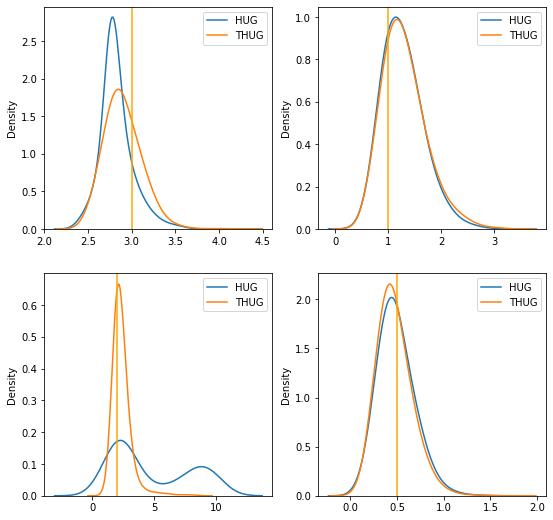

In [357]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))
AFTER = 0
SMOOTH = 0.4
# HUG
_ = sns.kdeplot(np.array(samples[AFTER:, 0]), ax=ax[0, 0], bw_method=SMOOTH, label='HUG')
_ = sns.kdeplot(np.array(samples[AFTER:, 1]), ax=ax[0, 1], bw_method=SMOOTH, label='HUG')
_ = sns.kdeplot(np.array(samples[AFTER:, 2]), ax=ax[1, 0], bw_method=SMOOTH, label='HUG')
_ = sns.kdeplot(np.array(samples[AFTER:, 3]), ax=ax[1, 1], bw_method=SMOOTH, label='HUG')
# RWM
# _ = sns.kdeplot(np.array(samplesRW[AFTER:, 0]), ax=ax[0, 0], bw_method=SMOOTH, label='RWM')
# _ = sns.kdeplot(np.array(samplesRW[AFTER:, 1]), ax=ax[0, 1], bw_method=SMOOTH, label='RWM')
# _ = sns.kdeplot(np.array(samplesRW[AFTER:, 2]), ax=ax[1, 0], bw_method=SMOOTH, label='RWM')
# _ = sns.kdeplot(np.array(samplesRW[AFTER:, 3]), ax=ax[1, 1], bw_method=SMOOTH, label='RWM')
# THUG
_ = sns.kdeplot(np.array(samplesTHUG[AFTER:, 0]), ax=ax[0, 0], bw_method=SMOOTH, label='THUG')
_ = sns.kdeplot(np.array(samplesTHUG[AFTER:, 1]), ax=ax[0, 1], bw_method=SMOOTH, label='THUG')
_ = sns.kdeplot(np.array(samplesTHUG[AFTER:, 2]), ax=ax[1, 0], bw_method=SMOOTH, label='THUG')
_ = sns.kdeplot(np.array(samplesTHUG[AFTER:, 3]), ax=ax[1, 1], bw_method=SMOOTH, label='THUG')
# Plot true θ0
ax[0, 0].axvline(θ0[0], c='orange')
ax[0, 1].axvline(θ0[1], c='orange')
ax[1, 0].axvline(θ0[2], c='orange')
ax[1, 1].axvline(θ0[3], c='orange')
ax[0, 0].legend()
ax[0, 1].legend()
ax[1, 0].legend()
ax[1, 1].legend()
plt.show()

In [358]:
from tangential_hug_functions import HugTangentialMultivariate

In [363]:
sTHUGqr, aTHUGqr = HugTangentialMultivariate(ξ0, 0.1, 5, 10000, 0.9, qGK, log_abc_posterior, Jf, method='qr')

In [364]:
sTHUGln, aTHUGln = HugTangentialMultivariate(ξ0, 0.1, 5, 10000, 0.9, qGK, log_abc_posterior, Jf, method='linear')